In [1]:
!git clone https://github.com/cloner174/mr.Sina.git

Cloning into 'mr.Sina'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 175 (delta 47), reused 122 (delta 22), pack-reused 0
Receiving objects: 100% (175/175), 23.21 MiB | 9.64 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Updating files: 100% (93/93), done.


In [2]:
%cd mr.Sina

/content/mr.Sina


In [3]:
# Import Packages :

import pandas as pd
from main import DataHandle


In [4]:
# Loading data

data = pd.read_csv( 'input/link_dataFinal.csv' , index_col=0)
data.shape

(199981, 4)

In [5]:
# Finding the nodes from data to pass to the DataHandel class!

data.columns

Index(['X_igraph_index', 'source', 'target', 'key'], dtype='object')

In [6]:
# Getting data ready by turn it into dict !

nodes = []

for node in data.loc[:,'source'].unique() :
    if node not in nodes :
        nodes.append(node)

for node in data.loc[:,'target'].unique() :
    if node not in nodes :
        nodes.append(node)

In [7]:
len(nodes)

6245

In [8]:
# Continue getting data ready this time by turnnig to dicts both !

links = dict(data)
nodes = pd.DataFrame(nodes)
nodes = nodes.set_axis(['id'], axis=1)
nodes = dict(nodes)
print(type(nodes), type(links))

<class 'dict'> <class 'dict'>


In [9]:
# This will prepare and preprocess the data :

Start = DataHandle( data_links= links, data_nodes= nodes)

In [10]:
Start.initial_keys()

 Unable to find any references or logic to split the nodes into layers 


In [ ]:
# This method finding the source and target palce and values in our data and Also
# find and initial the values for each layer !

#Start.initial_data()

In [ ]:
# The error seggest to us provide adv and pub nodes manually. This is beacuse our new_data
# had no obvious intialize laybel for whether a node is represent the advertisers or publishers

# So we need to pass these argumans to initial method from DataHandel class :
#            adertiser_nodes= ??? , publisher_nodes = ???

In [11]:
advertiser_campaigns = pd.read_csv( 'input/advertiser_campaigns.csv' , index_col=0)
publisher_contents = pd.read_csv( 'input/publisher_contents.csv' , index_col=0)
print(advertiser_campaigns.columns[13], '\n',publisher_contents.columns[25])

Advertiser ID 
 Media App Media - Media → Publisher ID


In [12]:
advertisers_nodes = list( advertiser_campaigns['Advertiser ID'].unique() )#It must be list
publishers_nodes = list( publisher_contents['Media App Media - Media → Publisher ID'].unique() )#It must be list

In [13]:
# Try again using our two new lists:

Start.initial_data( advertiser_nodes = advertisers_nodes , publisher_nodes = publishers_nodes )

# WorKed :)

In [14]:
layer_one_links, layer_two_links, interconnected_links = Start.modify_links()

Getting things Ready...


In [15]:
print( len(layer_one_links), len(layer_two_links), len(interconnected_links))

765 1531 2240


In [16]:
len(advertisers_nodes), len(publishers_nodes)

(6132, 3025)

In [17]:
from main import graph

In [18]:
G = graph.Graph(layer_one_name= 'Advertisers', layer_two_name= 'Publishers', nx_use = True )

In [20]:
# This is another use of add_links method for simple data :
G_train, G_test , g_nx = G.add_links( layer_one_links = layer_one_links ,
                                               layer_two_links = layer_two_links ,
                                               Interconnected_links = interconnected_links)

In [99]:
# Helper function to create feature set for Logistic Regression
def create_features(graph, edge_list):
    # Feature dictionary
    features = {
        'common_neighbors': [],
        'jaccard_coefficient': [],
        'preferential_attachment': []
    }
    labels = []

    for u, v in edge_list:
        # Common Neighbors
        common_neighbors = list(nx.common_neighbors(graph, u, v))
        features['common_neighbors'].append(len(common_neighbors))

        # Jaccard Coefficient
        jaccard_coeff = list(nx.jaccard_coefficient(graph, [(u, v)]))[0][2]
        features['jaccard_coefficient'].append(jaccard_coeff)

        # Preferential Attachment
        pref_attach = graph.degree(u) * graph.degree(v)
        features['preferential_attachment'].append(pref_attach)

        # Label (1 if edge exists, 0 otherwise)
        labels.append(1 if graph.has_edge(u, v) else 0)

    # Create DataFrame
    feature_df = pd.DataFrame(features)
    return feature_df, labels

# Create features and labels for training and test data
train_features, train_labels = create_features(G_train, list(G_train.edges) + list(nx.non_edges(G_train)))
test_features, test_labels = create_features(G_test, list(G_test.edges) + list(nx.non_edges(G_test)))

train_features.head(), len(train_labels), len(test_labels)


(   common_neighbors  jaccard_coefficient  preferential_attachment
 0                 0                  0.0                        8
 1                 0                  0.0                        8
 2                 0                  0.0                        9
 3                 0                  0.0                       80
 4                 0                  0.0                       90,
 84666,
 103740)

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# Initialize and train the logistic regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(train_features, train_labels)

# Predict on the test set
test_predictions = logistic_model.predict(test_features)
test_probabilities = logistic_model.predict_proba(test_features)[:, 1]

# Calculate metrics
roc_auc = roc_auc_score(test_labels, test_probabilities)
accuracy = accuracy_score(test_labels, test_predictions)

roc_auc, accuracy


(0.9774237359991691, 0.9685656448814344)

In [103]:
new_test_features, new_test_labels = create_features(g_nx, list(g_nx.edges) + list(nx.non_edges(g_nx)))

In [104]:
new_test_predictions = logistic_model.predict(new_test_features)

In [105]:
# Calculate metrics
roc_auc = roc_auc_score(new_test_labels, new_test_predictions)
accuracy = accuracy_score(new_test_labels, new_test_predictions)

roc_auc, accuracy

(0.8698473044809911, 0.892507781236105)

ابتدا سری به روش جنگل تصادفی میزنیم چون با استخراج ویژگی های عددی الان یک پیش بینی پیژگی محور محض را داریم

باید حلقه ی ویژگی ها ۳ بار تککرار شود

In [33]:
# Centrality Measures :
import networkx as nx

def calculate_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    return degree_centrality, betweenness_centrality, closeness_centrality

In [36]:
degree_centrality = nx.degree_centrality(G_train)
closeness_centrality = nx.closeness_centrality(G_train)

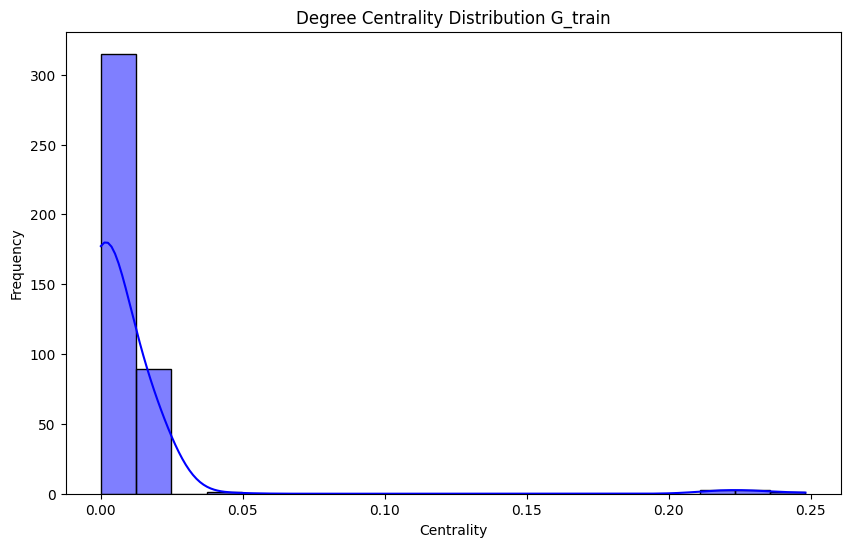

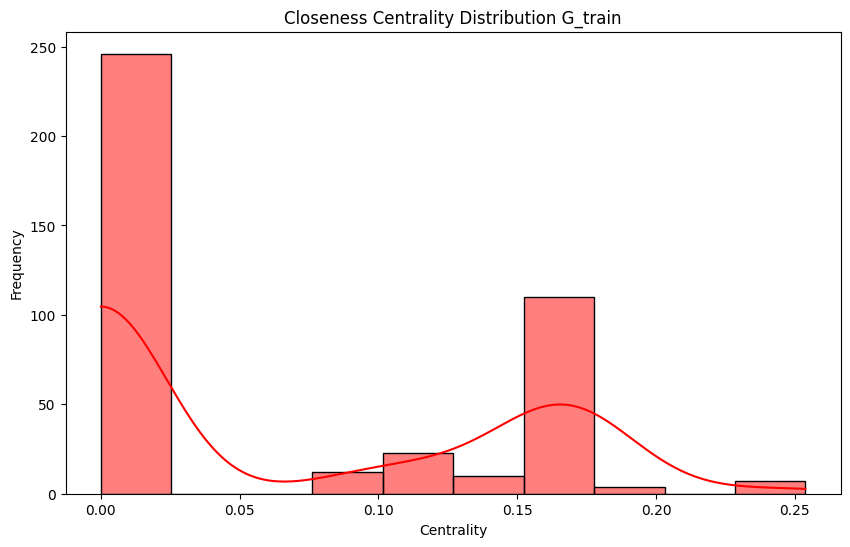

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

degree_values = list(degree_centrality.values())
plt.figure(figsize=(10, 6))
sns.histplot(degree_values, bins = 20, kde=True, color='blue')
plt.title('Degree Centrality Distribution G_train')
plt.xlabel('Centrality')
plt.ylabel('Frequency')
plt.show()

closeness_values = list(closeness_centrality.values())
plt.figure(figsize=(10, 6))
sns.histplot(closeness_values, kde=True, color='red')
plt.title('Closeness Centrality Distribution G_train')
plt.xlabel('Centrality')
plt.ylabel('Frequency')
plt.show()


In [43]:
degree_centrality = nx.degree_centrality(G_test)
closeness_centrality = nx.closeness_centrality(G_test)

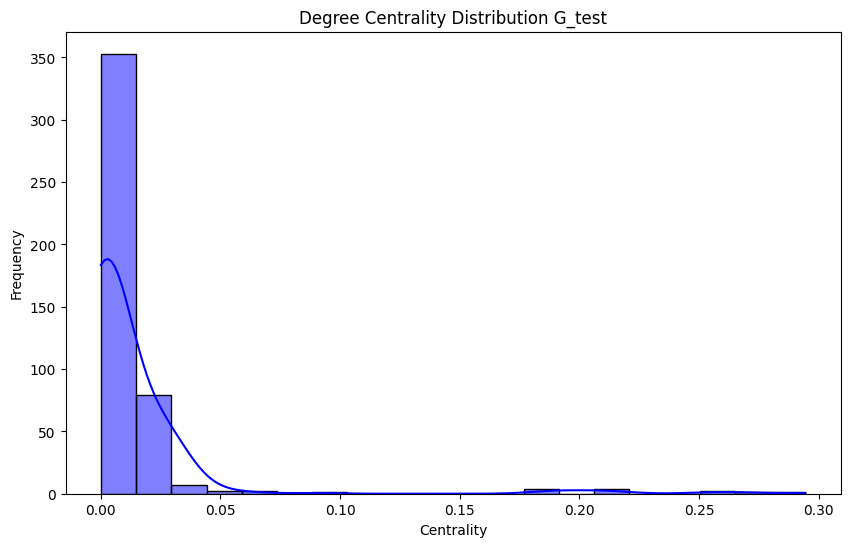

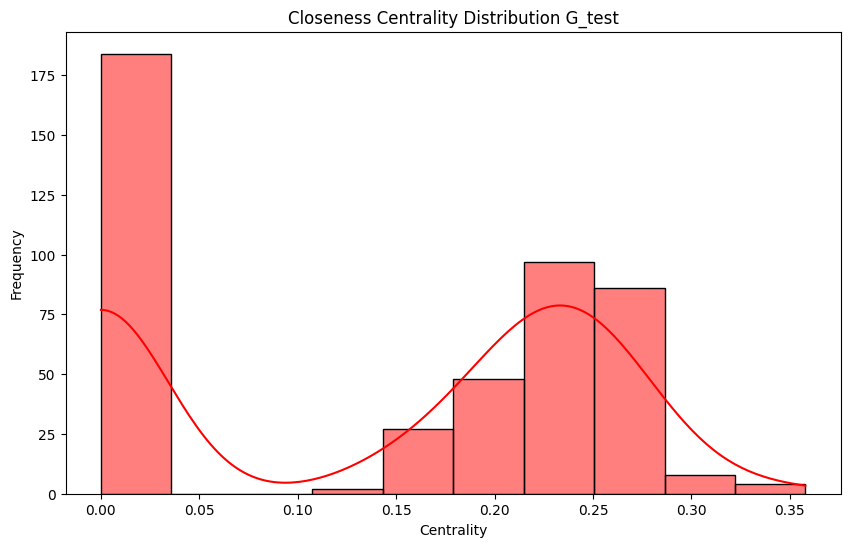

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

degree_values = list(degree_centrality.values())
plt.figure(figsize=(10, 6))
sns.histplot(degree_values, bins = 20, kde=True, color='blue')
plt.title('Degree Centrality Distribution G_test')
plt.xlabel('Centrality')
plt.ylabel('Frequency')
plt.show()

closeness_values = list(closeness_centrality.values())
plt.figure(figsize=(10, 6))
sns.histplot(closeness_values, kde=True, color='red')
plt.title('Closeness Centrality Distribution G_test')
plt.xlabel('Centrality')
plt.ylabel('Frequency')
plt.show()


In [45]:
degree_centrality = nx.degree_centrality(g_nx)
closeness_centrality = nx.closeness_centrality(g_nx)

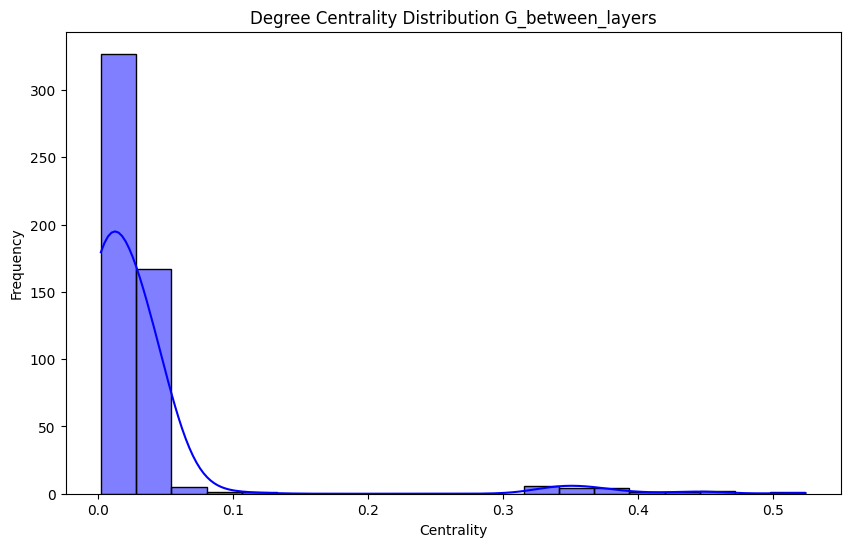

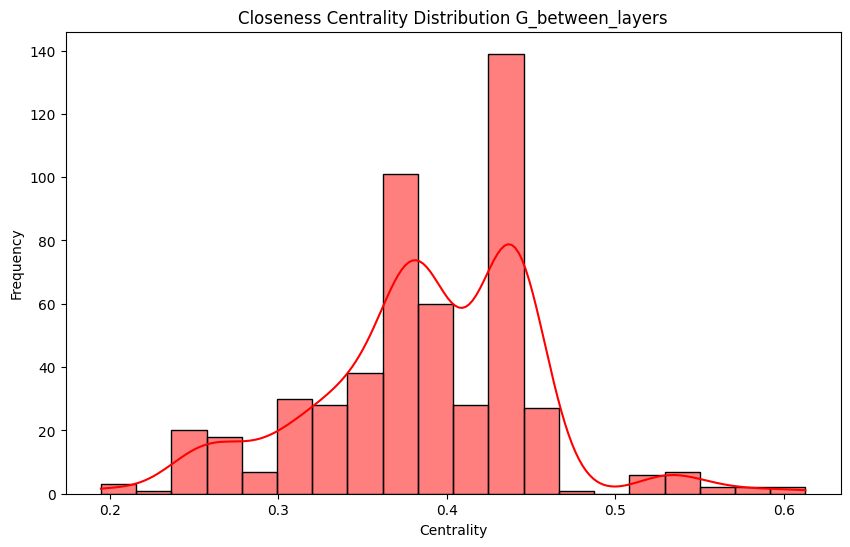

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

degree_values = list(degree_centrality.values())
plt.figure(figsize=(10, 6))
sns.histplot(degree_values, bins = 20, kde=True, color='blue')
plt.title('Degree Centrality Distribution G_between_layers')
plt.xlabel('Centrality')
plt.ylabel('Frequency')
plt.show()

closeness_values = list(closeness_centrality.values())
plt.figure(figsize=(10, 6))
sns.histplot(closeness_values, kde=True, color='red')
plt.title('Closeness Centrality Distribution G_between_layers')
plt.xlabel('Centrality')
plt.ylabel('Frequency')
plt.show()


In [48]:
G = G_train

In [51]:
G = G_test

In [54]:
G = g_nx

In [55]:

from itertools import combinations

# Graph
degree_centrality, betweenness_centrality, closeness_centrality = calculate_centrality_measures(G)
features = []
labels = []

# Calculating features for each pair of nodes:
for node1, node2 in combinations(G.nodes(), 2):

    # Centrality measures for node1 and node2
    degree_centrality_1 = degree_centrality[node1]
    degree_centrality_2 = degree_centrality[node2]
    betweenness_centrality_1 = betweenness_centrality[node1]
    betweenness_centrality_2 = betweenness_centrality[node2]
    closeness_centrality_1 = closeness_centrality[node1]
    closeness_centrality_2 = closeness_centrality[node2]

    # Directly compute and append features
    features.append((
        node1,
        node2,
        len(list(nx.common_neighbors(G, node1, node2))),  # Common Neighbors
        next(nx.preferential_attachment(G, [(node1, node2)]))[2],  # Preferential Attachment
        next(nx.resource_allocation_index(G, [(node1, node2)]))[2],  # Resource Allocation
        next(nx.adamic_adar_index(G, [(node1, node2)]))[2],  # Adamic Adar
        next(nx.jaccard_coefficient(G, [(node1, node2)]))[2] , # Jaccard Coefficient
        (degree_centrality_1 + degree_centrality_2) / 2,
        (betweenness_centrality_1 + betweenness_centrality_2) / 2,
        (closeness_centrality_1 + closeness_centrality_2) / 2
    ))

    # Existence of links between nodes (1 or 0)
    labels.append(1 if G.has_edge(node1, node2) else 0)

# Creating a DataFrame from the features and labels
features_df = pd.DataFrame(features,
                           columns=['node1','node2','Common Neighbors',
                                    'Preferential Attachment', 'Resource Allocation',
                                    'Adamic Adar', 'Jaccard Coefficient', 'Average Degree Centrality',
                                    'Average Betweenness Centrality', 'Average Closeness Centrality'])

features_df['Label'] = labels

# Now features_df is ready to use in a machine learning model


In [50]:
features_df.to_csv('G_train_df.csv', index=False)

In [53]:
features_df.to_csv('G_test_df.csv', index=False)

In [56]:
features_df.to_csv('G_nx_df.csv', index=False)

In [57]:
data1 = pd.read_csv('/content/mr.Sina/G_train_df.csv')
data2 = pd.read_csv('/content/mr.Sina/G_test_df.csv')
data3 = pd.read_csv('/content/mr.Sina/G_nx_df.csv')

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X1 = data1.drop(['node1','node2','Label'], axis=1)  # Features
y1 = data1['Label']  # Labels

In [60]:
X2 = data2.drop(['node1','node2','Label'], axis=1)  # Features
y2 = data2['Label']  # Labels

In [61]:
X3 = data3.drop(['node1','node2','Label'], axis=1)  # Features
y3 = data3['Label']  # Labels

In [62]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [63]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [64]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [65]:
X_train1.shape, X_train2.shape, X_train3.shape, y_train1.shape, y_train2.shape, y_test3.shape

((67732, 8), (82992, 8), (107952, 8), (67732,), (82992,), (26988,))

In [66]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix


# Prepare data
X = np.array(X_train1)
y = np.array(y_train1)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train model
    clf = RandomForestClassifier(n_estimators=100, random_state=42, verbose = 1)
    clf.fit(X_train, y_train)

    # Predict probabilities
    probabilities = clf.predict_proba(X_test)[:, 1]

    # Adjust threshold here if needed :
    threshold = 0.5
    predictions = (probabilities >= threshold).astype(int)

    # Calculate metrics
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, predictions, average='binary')
    accuracy = accuracy_score(y_test, predictions)
    print(f"Average Accuracy: {precision}")
    print(f"Average Precision: {recall}")
    print(f"Average Recall: {fscore}")
    print(f"Average F1-Score: {accuracy}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.9803921568627451
Average Precision: 0.8771929824561403
Average Recall: 0.9259259259259259
Average F1-Score: 0.998819013876587


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.9824561403508771
Average Precision: 0.9824561403508771
Average Recall: 0.9824561403508771
Average F1-Score: 0.9997047534691468


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Average Accuracy: 0.9814814814814815
Average Precision: 0.9464285714285714
Average Recall: 0.9636363636363636
Average F1-Score: 0.9994094197549092


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.9642857142857143
Average Precision: 0.9642857142857143
Average Recall: 0.9642857142857143
Average F1-Score: 0.9994094197549092


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.9629629629629629
Average Precision: 0.9285714285714286
Average Recall: 0.9454545454545454
Average F1-Score: 0.9991141296323638


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 1.0
Average Precision: 0.8928571428571429
Average Recall: 0.9433962264150945
Average F1-Score: 0.9991141296323638


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 1.0
Average Precision: 0.9824561403508771
Average Recall: 0.9911504424778761
Average F1-Score: 0.9998523549387273


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.9814814814814815
Average Precision: 0.9298245614035088
Average Recall: 0.954954954954955
Average F1-Score: 0.9992617746936365


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 1.0
Average Precision: 0.9824561403508771
Average Recall: 0.9911504424778761
Average F1-Score: 0.9998523549387273


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s


Average Accuracy: 0.9649122807017544
Average Precision: 0.9649122807017544
Average Recall: 0.9649122807017544
Average F1-Score: 0.9994094197549092


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [84]:
X = np.array(X_train2)
y = np.array(y_train2)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train model
    clf = RandomForestClassifier(n_estimators=100, random_state=42, verbose = 1)
    clf.fit(X_train, y_train)

    # Predict probabilities
    probabilities = clf.predict_proba(X_test)[:, 1]

    # Adjust threshold here if needed :
    threshold = 0.5
    predictions = (probabilities >= threshold).astype(int)

    # Calculate metrics
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, predictions, average='binary')
    accuracy = accuracy_score(y_test, predictions)
    #confuse_matrix.append(confusion_matrix(y_test, predictions))
    #all_predictions.extend(predictions)
    #all_actuals.extend(y_test)
    print(f"Average Accuracy: {precision}")
    print(f"Average Precision: {recall}")
    print(f"Average Recall: {fscore}")
    print(f"Average F1-Score: {accuracy}")


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.968421052631579
Average Precision: 0.8518518518518519
Average Recall: 0.9064039408866994
Average F1-Score: 0.997710843373494


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.9514563106796117
Average Precision: 0.9074074074074074
Average Recall: 0.9289099526066351
Average F1-Score: 0.9981927710843373


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.9770114942528736
Average Precision: 0.794392523364486
Average Recall: 0.8762886597938144
Average F1-Score: 0.9971080853114833


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Average Accuracy: 0.9795918367346939
Average Precision: 0.897196261682243
Average Recall: 0.9365853658536586
Average F1-Score: 0.9984335462103868


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


Average Accuracy: 0.9622641509433962
Average Precision: 0.9532710280373832
Average Recall: 0.9577464788732395
Average F1-Score: 0.9989155319918063


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.9433962264150944
Average Precision: 0.9345794392523364
Average Recall: 0.9389671361502347
Average F1-Score: 0.9984335462103868


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.9433962264150944
Average Precision: 0.9345794392523364
Average Recall: 0.9389671361502347
Average F1-Score: 0.9984335462103868


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.9795918367346939
Average Precision: 0.8888888888888888
Average Recall: 0.9320388349514563
Average F1-Score: 0.9983130497650319


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Average Accuracy: 0.9693877551020408
Average Precision: 0.8796296296296297
Average Recall: 0.9223300970873787
Average F1-Score: 0.9980720568743222


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s


Average Accuracy: 0.9444444444444444
Average Precision: 0.9444444444444444
Average Recall: 0.9444444444444444
Average F1-Score: 0.9985540426557417


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [85]:
X = np.array(X_train3)
y = np.array(y_train3)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train model
    #clf = RandomForestClassifier(n_estimators=100, random_state=42, verbose = 1)
    clf.fit(X_train, y_train)

    # Predict probabilities
    probabilities = clf.predict_proba(X_test)[:, 1]

    # Adjust threshold here if needed :
    threshold = 0.5
    predictions = (probabilities >= threshold).astype(int)

    # Calculate metrics
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, predictions, average='binary')
    accuracy = accuracy_score(y_test, predictions)
    #confuse_matrix.append(confusion_matrix(y_test, predictions))
    #all_predictions.extend(predictions)
    #all_actuals.extend(y_test)
    print(f"Average Accuracy: {precision}")
    print(f"Average Precision: {recall}")
    print(f"Average Recall: {fscore}")
    print(f"Average F1-Score: {accuracy}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Average Accuracy: 0.9754601226993865
Average Precision: 0.9520958083832335
Average Recall: 0.9636363636363636
Average F1-Score: 0.9977769544275658


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Average Accuracy: 0.9744408945686901
Average Precision: 0.9131736526946108
Average Recall: 0.9428129829984544
Average F1-Score: 0.9965728047424972


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Average Accuracy: 0.9842271293375394
Average Precision: 0.9369369369369369
Average Recall: 0.9600000000000001
Average F1-Score: 0.9975914775358963


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Average Accuracy: 0.9873015873015873
Average Precision: 0.9311377245508982
Average Recall: 0.9583975346687211
Average F1-Score: 0.9974988420565076


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Average Accuracy: 0.9870550161812298
Average Precision: 0.9131736526946108
Average Recall: 0.9486780715396579
Average F1-Score: 0.996943029180176


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Average Accuracy: 0.9842767295597484
Average Precision: 0.937125748502994
Average Recall: 0.9601226993865032
Average F1-Score: 0.9975914775358963


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Average Accuracy: 0.9845201238390093
Average Precision: 0.9520958083832335
Average Recall: 0.9680365296803654
Average F1-Score: 0.9980546549328393


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Average Accuracy: 0.9873817034700315
Average Precision: 0.937125748502994
Average Recall: 0.9615975422427037
Average F1-Score: 0.9976841130152848


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Average Accuracy: 0.9873417721518988
Average Precision: 0.9341317365269461
Average Recall: 0.96
Average F1-Score: 0.9975914775358963


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.1s


Average Accuracy: 0.9968051118210862
Average Precision: 0.9341317365269461
Average Recall: 0.9644513137557961
Average F1-Score: 0.9978693839740621


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


In [86]:
new_predict_on_unseen1 = clf.predict(X_test1)
new_predict_on_unseen2 = clf.predict(X_test2)
new_predict_on_unseen3 = clf.predict(X_test3)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


In [87]:
confuse_matrix1 = []
confuse_matrix2 = []
confuse_matrix3 = []

In [88]:
precision1, recall1, fscore1, _ = precision_recall_fscore_support(y_test1, new_predict_on_unseen1, average='binary')
accuracy1 = accuracy_score(y_test1, new_predict_on_unseen1)
confuse_matrix1.append(confusion_matrix(y_test1, new_predict_on_unseen1))

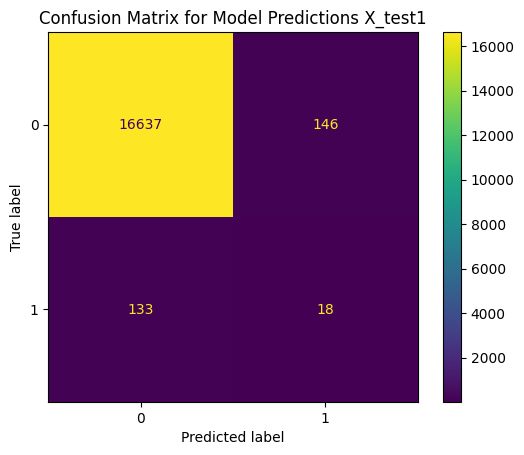

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test1, new_predict_on_unseen1)
plt.title('Confusion Matrix for Model Predictions X_test1')
plt.show()

In [90]:
precision2, recall2, fscore2, _ = precision_recall_fscore_support(y_test2, new_predict_on_unseen2, average='binary')
accuracy2 = accuracy_score(y_test2, new_predict_on_unseen2)
confuse_matrix2.append(confusion_matrix(y_test2, new_predict_on_unseen2))

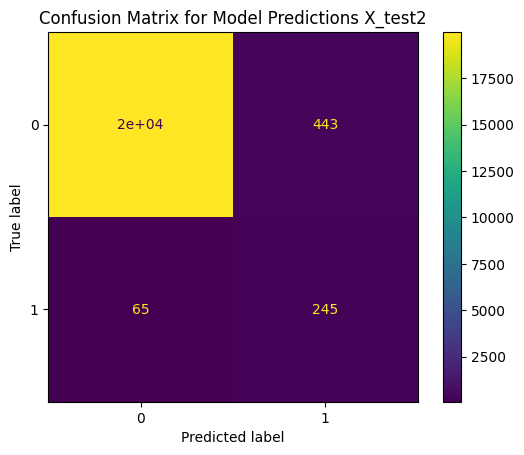

In [91]:
ConfusionMatrixDisplay.from_predictions(y_test2, new_predict_on_unseen2)
plt.title('Confusion Matrix for Model Predictions X_test2')
plt.show()

In [92]:
precision3, recall3, fscore3, _ = precision_recall_fscore_support(y_test3, new_predict_on_unseen3, average='binary')
accuracy3 = accuracy_score(y_test3, new_predict_on_unseen3)
confuse_matrix3.append(confusion_matrix(y_test3, new_predict_on_unseen3))

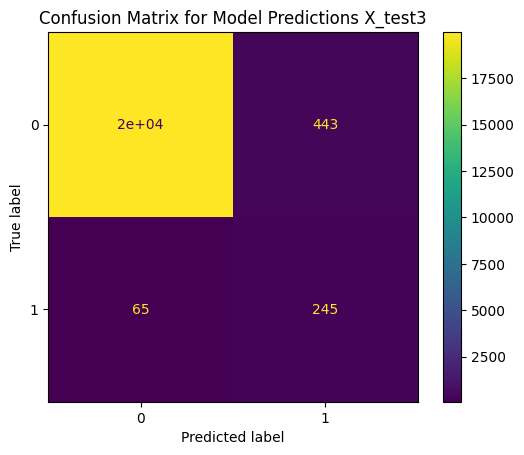

In [93]:
ConfusionMatrixDisplay.from_predictions(y_test2, new_predict_on_unseen2)
plt.title('Confusion Matrix for Model Predictions X_test3')
plt.show()

In [94]:

print(f"X_test1 Accuracy: {accuracy1}")
print(f"X_test1 Precision: {precision1}")
print(f"X_test1 Recall: {recall1}")
print(f"X_test1 F1-Score: {fscore1}")

print("")
print("")

print(f"X_test2 Accuracy: {accuracy2}")
print(f"X_test2 Precision: {precision2}")
print(f"X_test2 Recall: {recall2}")
print(f"X_test2 F1-Score: {fscore2}")

print("")
print("")

print(f"X_test3 Accuracy: {accuracy3}")
print(f"X_test3 Precision: {precision3}")
print(f"X_test3 Recall: {recall3}")
print(f"X_test3 F1-Score: {fscore3}")

X_test1 Accuracy: 0.983524270698004
X_test1 Precision: 0.10975609756097561
X_test1 Recall: 0.11920529801324503
X_test1 F1-Score: 0.11428571428571428


X_test2 Accuracy: 0.9755157123578176
X_test2 Precision: 0.3561046511627907
X_test2 Recall: 0.7903225806451613
X_test2 F1-Score: 0.4909819639278557


X_test3 Accuracy: 0.9978508966948273
X_test3 Precision: 0.9933155080213903
X_test3 Recall: 0.9334170854271356
X_test3 F1-Score: 0.9624352331606217


In [100]:
test_probabilities1 = clf.predict_proba(X_test1)[:, 1]
test_probabilities2 = clf.predict_proba(X_test2)[:, 1]
test_probabilities3 = clf.predict_proba(X_test3)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


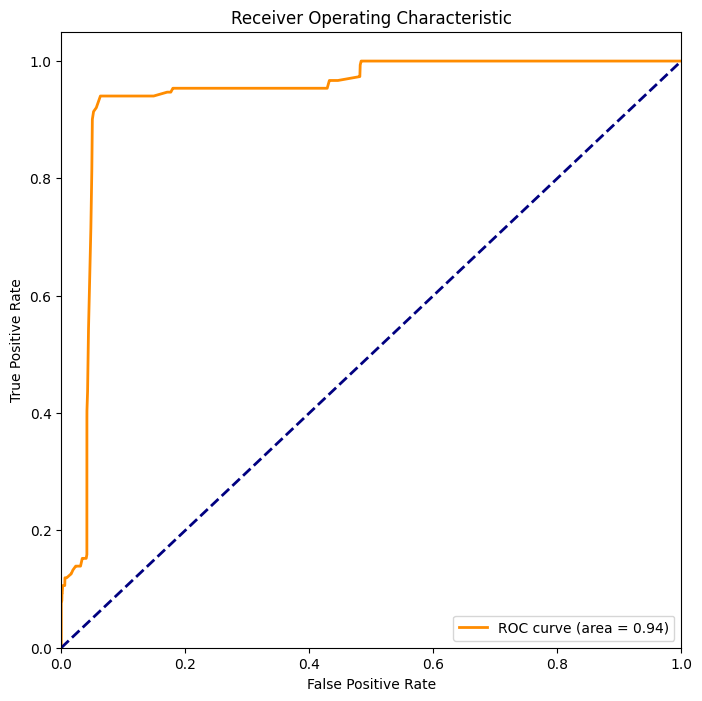

In [101]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test1, test_probabilities1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic y_test1 VS test_probabilities1')
plt.legend(loc="lower right")
plt.show()


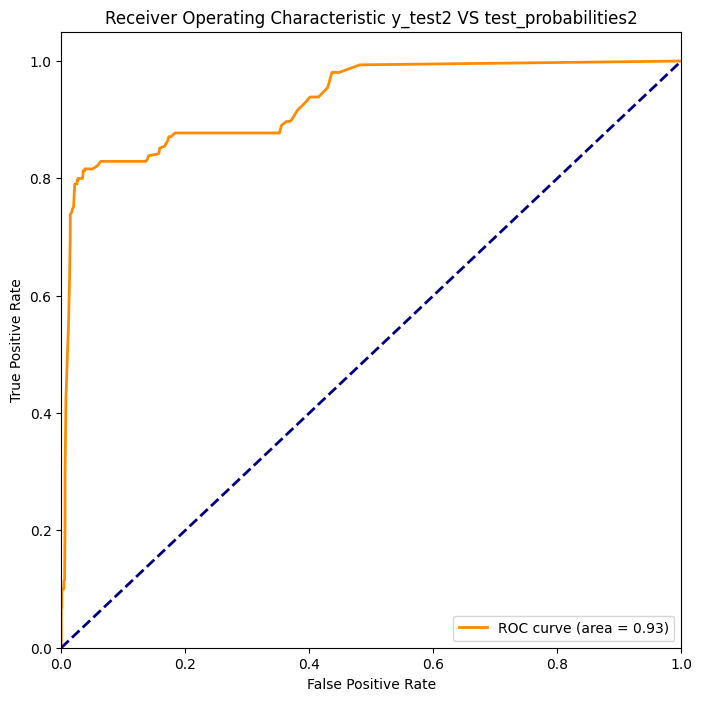

In [102]:

fpr, tpr, _ = roc_curve(y_test2, test_probabilities2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic y_test2 VS test_probabilities2')
plt.legend(loc="lower right")
plt.show()


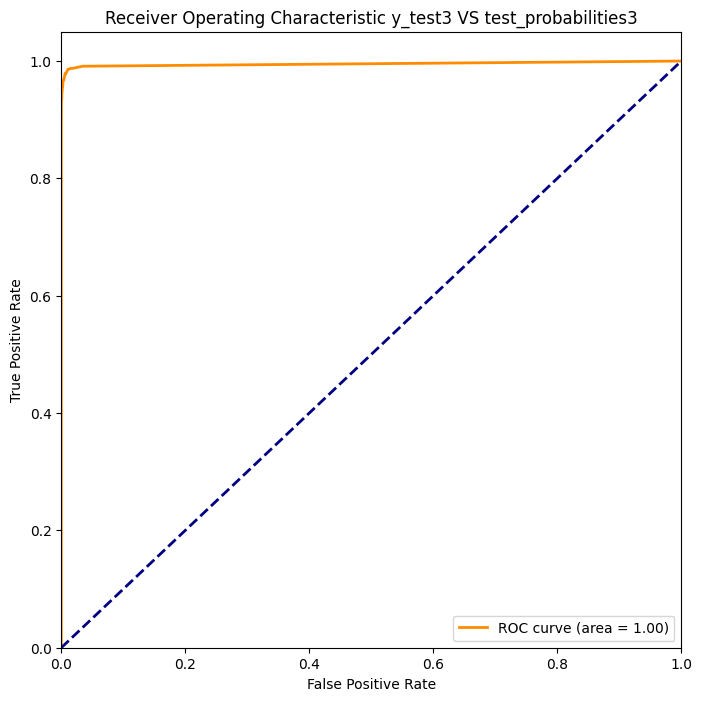

In [103]:

fpr, tpr, _ = roc_curve(y_test3, test_probabilities3)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic y_test3 VS test_probabilities3')
plt.legend(loc="lower right")
plt.show()


In [148]:
# Creating DataFrame
X_test1_results_df = pd.DataFrame({
    'Actual from X_test1': y_test1,
    'Predicted from X_test1': new_predict_on_unseen1,


})

X_test2_results_df = pd.DataFrame({
    'Actual from X_test2': y_test2,
    'Predicted from X_test2': new_predict_on_unseen2,
})

X_test3_results_df = pd.DataFrame({
    'Actual from X_test3': y_test3,
    'Predicted from X_test3': new_predict_on_unseen3
})

# Saving DataFrame to CSV
csv_path = 'new_predictions_and_actuals_from X_test1.csv'
X_test1_results_df.to_csv(csv_path, index=False)

csv_path = 'new_predictions_and_actuals_from X_test2.csv'
X_test2_results_df.to_csv(csv_path, index=False)

csv_path = 'new_predictions_and_actuals_from X_test3.csv'
X_test3_results_df.to_csv(csv_path, index=False)

print("Saved predictions and actual labels")



Saved predictions and actual labels


In [ ]:
# Confusion Matrix Guide :
#    [ [TN    FP]
#      [FN    TP] ]

In [139]:
# Here we look at the Confusion Matrix :

tn_fn = []
fp_tp = []
for TNFP_FNTP in confuse_matrix1:

    for TN_and_FN_or_FP_and_TP in TNFP_FNTP :
        TN_and_FN = TN_and_FN_or_FP_and_TP[0]
        FP_and_TP = TN_and_FN_or_FP_and_TP[1]
        tn_fn.append(TN_and_FN)
        fp_tp.append(FP_and_TP)
tn = []
fn = []
fp = []
tp = []
for i in range(0, len(tn_fn), 2) :
    tn.append(tn_fn[i])
for i in range(1, len(tn_fn), 2) :
    fn.append(tn_fn[i])
for i in range(0, len(tn_fn), 2) :
    fp.append(fp_tp[i])
for i in range(1, len(tn_fn), 2) :
    tp.append(fp_tp[i])

tn_fn = []
fp_tp = []
for TNFP_FNTP in confuse_matrix2:

    for TN_and_FN_or_FP_and_TP in TNFP_FNTP :
        TN_and_FN = TN_and_FN_or_FP_and_TP[0]
        FP_and_TP = TN_and_FN_or_FP_and_TP[1]
        tn_fn.append(TN_and_FN)
        fp_tp.append(FP_and_TP)

for i in range(0, len(tn_fn), 2) :
    tn.append(tn_fn[i])
for i in range(1, len(tn_fn), 2) :
    fn.append(tn_fn[i])
for i in range(0, len(tn_fn), 2) :
    fp.append(fp_tp[i])
for i in range(1, len(tn_fn), 2) :
    tp.append(fp_tp[i])

tn_fn = []
fp_tp = []
for TNFP_FNTP in confuse_matrix3:

    for TN_and_FN_or_FP_and_TP in TNFP_FNTP :
        TN_and_FN = TN_and_FN_or_FP_and_TP[0]
        FP_and_TP = TN_and_FN_or_FP_and_TP[1]
        tn_fn.append(TN_and_FN)
        fp_tp.append(FP_and_TP)

for i in range(0, len(tn_fn), 2) :
    tn.append(tn_fn[i])
for i in range(1, len(tn_fn), 2) :
    fn.append(tn_fn[i])
for i in range(0, len(tn_fn), 2) :
    fp.append(fp_tp[i])
for i in range(1, len(tn_fn), 2) :
    tp.append(fp_tp[i])

print(f" The Max True Negatives (TN): {max(tn)} \n",
      f"The min False Negatives(FN): {min(fn)} \n",
      f"The min False Positives(FP): {min(fp)} \n",
      f"The Max True Positives (TP): {max(tp)} \n")

print(f" The min True Negatives (TN): {min(tn)} \n",
      f"The Max False Negatives(FN): {max(fn)} \n",
      f"The Max False Positives(FP): {max(fp)} \n",
      f"The min True Positives (TP): {min(tp)} \n")

 The Max True Negatives (TN): 26187 
 The min False Negatives(FN): 53 
 The min False Positives(FP): 5 
 The Max True Positives (TP): 743 

 The min True Negatives (TN): 16637 
 The Max False Negatives(FN): 133 
 The Max False Positives(FP): 443 
 The min True Positives (TP): 18 



In [ ]:
#%pip install torch_geometric

بگذارید رگرسیون را تست کنیم

In [ ]:
# data1 = train, data2 = train , data3 = test

In [107]:
X_train1 = data1.drop(['node1','node2','Label'], axis=1)  # Features
y_train1 = data1['Label']  # Labels

X_train2 = data2.drop(['node1','node2','Label'], axis=1)  # Features
y_train2 = data2['Label']  # Labels

X_test = data3.drop(['node1','node2','Label'], axis=1)  # Features
y_test = data3['Label']  # Labels

In [108]:
train_features = np.array(X_train1)
train_labels = np.array(y_train1)

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# Initialize and train the logistic regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(train_features, train_labels)

LogisticRegression(max_iter=1000, random_state=42)

In [110]:
train_features = np.array(X_train2)
train_labels = np.array(y_train2)

In [111]:
logistic_model.fit(train_features, train_labels)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Now the completly new and unseen :


In [112]:
test_features = np.array(X_test)
test_labels = np.array(y_test)

In [113]:
# Predict on the test set
test_predictions = logistic_model.predict(test_features)
test_probabilities = logistic_model.predict_proba(test_features)[:, 1]

# Calculate metrics
roc_auc = roc_auc_score(test_labels, test_probabilities)
accuracy = accuracy_score(test_labels, test_predictions)

roc_auc, accuracy

(0.9536496239198189, 0.8888987698236254)

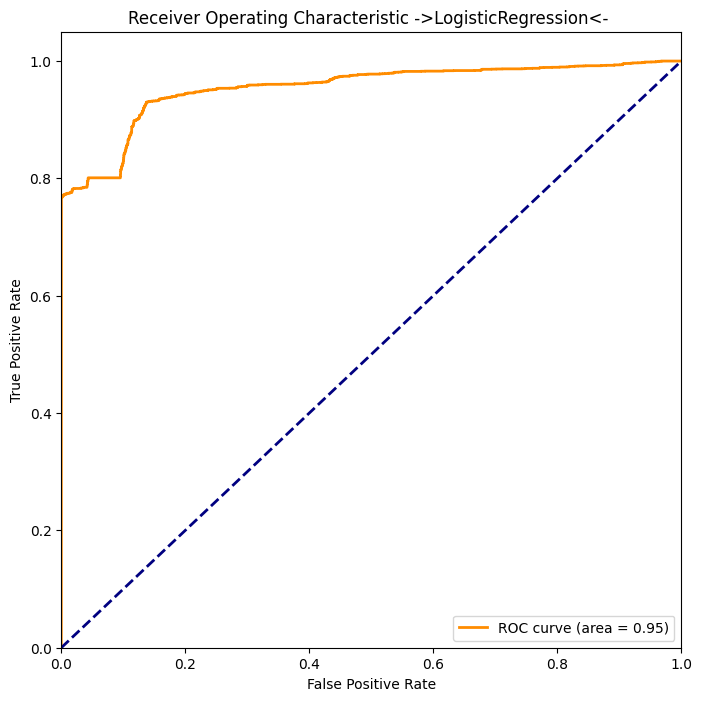

In [115]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_labels, test_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic ->LogisticRegression<- ')
plt.legend(loc="lower right")
plt.show()
